In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prophet import Prophet

In [4]:
# read the dataframe
df = pd.read_csv("all_stocks_5yr.csv").rename(columns={'Name':'ticks'})
df.loc[:, 'date'] = pd.to_datetime(df.loc[:, 'date'], format='%Y/%m/%d')


def get_ts(full_df, stock_name=''):
    
    return full_df[full_df['ticks']==stock_name].reset_index(drop=True)
    
print("Total stocks: ", list(set(df['ticks'].values)))    

Total stocks:  ['PVH', 'WMB', 'MRK', 'CHD', 'FOXA', 'WY', 'NTRS', 'ALB', 'HSY', 'TAP', 'BAC', 'FB', 'CHRW', 'NOC', 'CTAS', 'VLO', 'SNPS', 'EL', 'HPQ', 'HIG', 'BAX', 'PXD', 'MAA', 'HST', 'SRCL', 'DE', 'KMX', 'PWR', 'EXC', 'APH', 'CHTR', 'ETFC', 'MCHP', 'CTXS', 'ZBH', 'CSX', 'FBHS', 'UAL', 'FLR', 'FFIV', 'HON', 'TMO', 'VZ', 'FDX', 'ABT', 'GILD', 'NKE', 'RE', 'DGX', 'CBS', 'ALK', 'MOS', 'RRC', 'INCY', 'COTY', 'BRK.B', 'MPC', 'EA', 'ESRX', 'O', 'MAT', 'ZTS', 'SCG', 'RJF', 'NSC', 'AZO', 'WDC', 'UHS', 'SJM', 'FISV', 'TGT', 'STT', 'DHI', 'DOV', 'PCLN', 'ANTM', 'CFG', 'CI', 'HII', 'ALLE', 'UPS', 'EXR', 'YUM', 'RHI', 'UDR', 'FTV', 'HES', 'STI', 'CCI', 'AES', 'MMC', 'BSX', 'EMR', 'XEL', 'KMI', 'RHT', 'HAL', 'MDT', 'SBAC', 'UAA', 'CMG', 'LYB', 'SLG', 'NRG', 'AKAM', 'MSFT', 'TWX', 'CBOE', 'BBT', 'GE', 'COST', 'CMA', 'LUK', 'ITW', 'LMT', 'ULTA', 'MDLZ', 'SHW', 'KEY', 'SWKS', 'TRIP', 'SYY', 'AET', 'UNH', 'VAR', 'PGR', 'BK', 'WHR', 'AMP', 'MET', 'XLNX', 'KO', 'CERN', 'KLAC', 'NI', 'BF.B', 'GPC', 'IR'

In [5]:
stock_name = 'AAPL'
stock_df = get_ts(df,'AAPL')
stock_df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})

# company dict for respective ticks (TOP 10 STOCKS BY AVERAGE TRAE VOLUME)
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }

# Define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

# Function to visualize trade volume of stocks
def trade_vol(df):
    
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol
    max_y = df['volume'].max()
    # y coord for min trade vol
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    


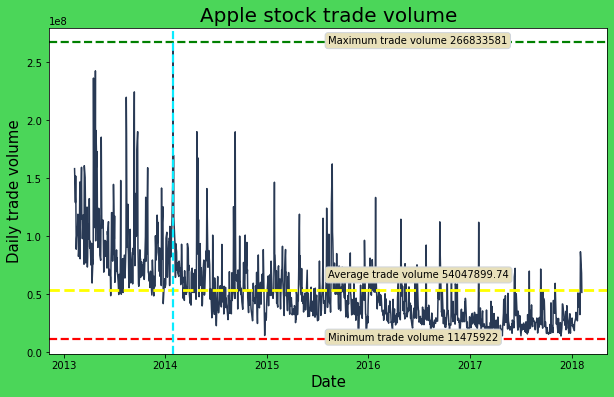

In [6]:
# plot of all stocks trade volume
trade_vol(dailyfunc(stock_df))

In [7]:
#stock_df
from business_duration import businessDuration
from datetime import datetime

#https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
holiday_cols = ['holiday', 'ds', 'lower_window', 'upper_window']
last_date = '2016-12-31'

train_df = stock_df[stock_df['date']<=last_date].reset_index(drop=True).rename(columns={'date':'ds', 'close':'y'})
last_training_date = train_df['ds'].max() #forecast_prophet['ds'].iloc[-12]

print("Train df Tail")
print(train_df.tail())


holidays = pd.read_csv('US Holiday Dates (2004-2021).csv').rename(columns={'Date':'ds', 'Holiday':'holiday'})
holidays['lower_window'] = 0
holidays['upper_window'] = 0
holidays = holidays[holiday_cols].sort_values(by=['ds'], ascending=True).reset_index(drop=True)

m = Prophet()
m.fit(train_df)

#prediction_days = businessDuration(startdate=stock_df[stock_df['date']>last_training_date]['date'].min(),enddate=stock_df[stock_df['date']>last_training_date]['date'].max(),unit='day')
prediction_days = (stock_df[stock_df['date']>last_training_date]['date'].max() - train_df['ds'].max()).days - 1
print("No. of days to predict ahead: ", prediction_days)

future = m.make_future_dataframe(periods=int(prediction_days))
forecast = m.predict(future)
forecast['dow'] = [datetime.strftime(date, '%a') for date in forecast['ds']]

print(holidays, future)
print("Forecast: --------------------")
print(forecast)

Train df Tail
            ds    open      high     low       y    volume ticks  \
977 2016-12-23  115.59  116.5200  115.59  116.52  14249484  AAPL   
978 2016-12-27  116.52  117.8000  116.49  117.26  18296855  AAPL   
979 2016-12-28  117.52  118.0166  116.20  116.76  20905892  AAPL   
980 2016-12-29  116.45  117.1095  116.40  116.73  15039519  AAPL   
981 2016-12-30  116.65  117.2000  115.43  115.82  30586265  AAPL   

     daily return  daily_mean co_name  
977      0.804568  116.055000   Apple  
978      0.635084  117.017500   Apple  
979     -0.646698  117.124150   Apple  
980      0.240447  116.672375   Apple  
981     -0.711530  116.275000   Apple  


19:29:52 - cmdstanpy - INFO - Chain [1] start processing
19:29:52 - cmdstanpy - INFO - Chain [1] done processing


No. of days to predict ahead:  403
                         holiday          ds  lower_window  upper_window
0                 New Year's Day  2004-01-01             0             0
1    Martin Luther King, Jr. Day  2004-01-19             0             0
2                Valentine’s Day  2004-02-14             0             0
3          Washington's Birthday  2004-02-16             0             0
4                 Eastern Easter  2004-04-11             0             0
..                           ...         ...           ...           ...
337             Thanksgiving Eve  2021-11-24             0             0
338             Thanksgiving Day  2021-11-25             0             0
339                Christmas Eve  2021-12-24             0             0
340                Christmas Day  2021-12-25             0             0
341               New Year’s Eve  2021-12-31             0             0

[342 rows x 4 columns]              ds
0    2013-02-08
1    2013-02-11
2    2013-02-12
3

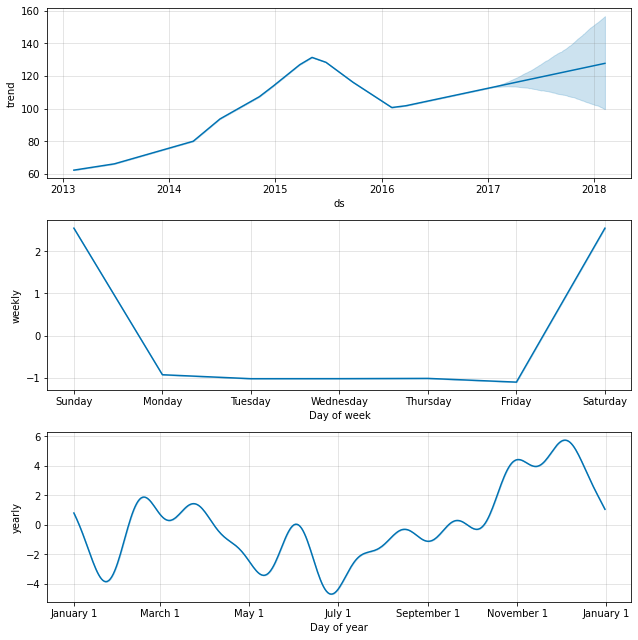

In [8]:
fig = m.plot_components(forecast)

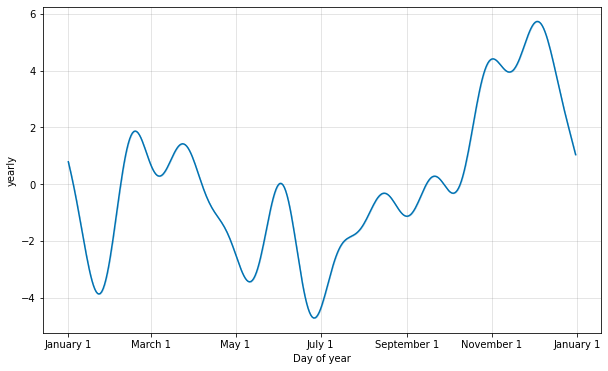

In [9]:
from prophet.plot import plot_yearly
a = plot_yearly(m)


19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing


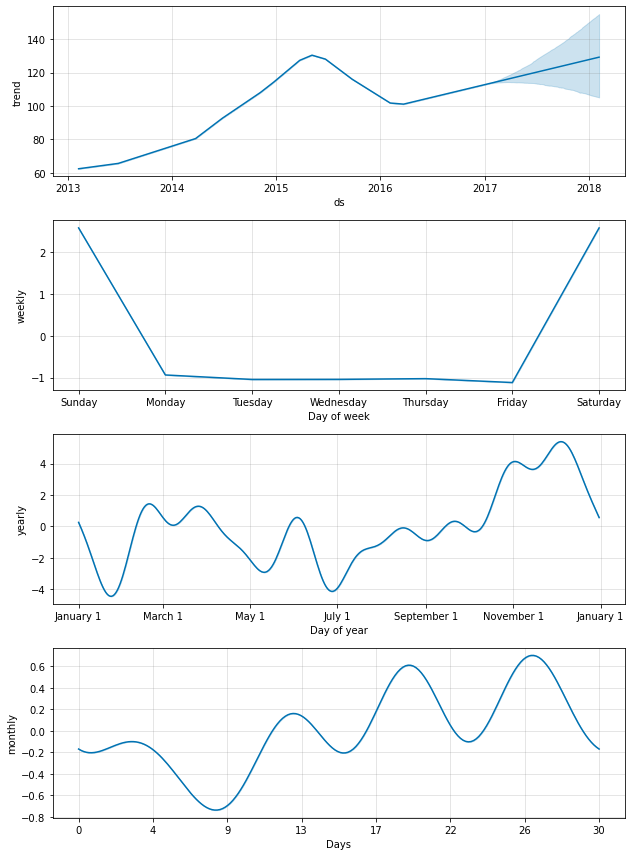

In [10]:
'''
Additive: If the data projections looks constant such that even if the trend increase the peaks of the data will not vary much and will be constant through out the series.

Multiplicative: If the series is having high peaks such that the data looks exaggerated with the change in the trend. Here the data series looks like jumping from high data points to lower data points.
'''

m = Prophet(weekly_seasonality=False)
#m = Prophet(seasonality_mode='multiplicative')
m = Prophet(seasonality_mode='additive')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='yearly', period=365.5, fourier_order=10)
forecast = m.fit(train_df).predict(future)
fig = m.plot_components(forecast)

Last training date:  2016-12-30 00:00:00
RMSE:  34.42
MAPE (Lower, Mid, Upper):  28.33 % 21.07 % 13.57 %


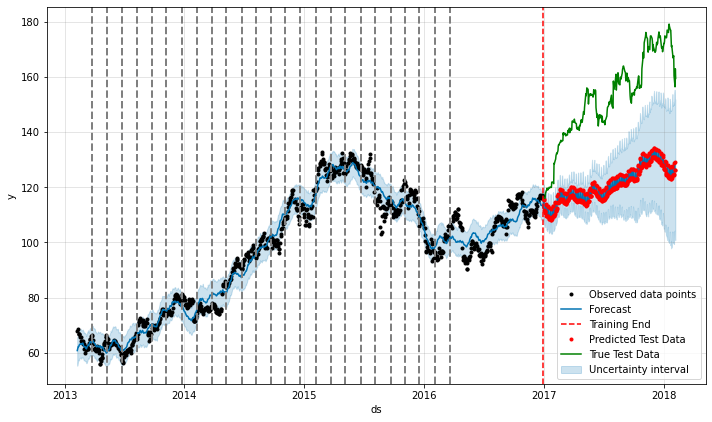

In [11]:
# Plot the model

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# plot the time series 
forecast_plot = m.plot(forecast) #yhat is being plotted

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
print("Last training date: ", last_training_date)

axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line

plt.plot(forecast[forecast['ds']>last_training_date]['ds'], forecast[forecast['ds']>last_training_date]['yhat'], 'ro', markersize=3, label='Predicted Test Data')
plt.plot(stock_df[stock_df['date']>last_training_date]['date'], stock_df[stock_df['date']>last_training_date]['close'], 'green', markersize=3, label='True Test Data')


# show the legend to distinguish between the lines
plt.legend()
#rms = root_mean_squared_error(y_actual, y_predicted)
comp_df = stock_df[stock_df['date']>last_training_date].rename(columns={'date':'ds'}).merge(forecast[forecast['ds']>last_training_date], on=['ds'], how='inner')
rmse = np.sqrt(mean_squared_error(comp_df['close'].values, \
                                  comp_df['yhat'].values))
mape_lower, mape, mape_upper = mean_absolute_percentage_error(y_true = comp_df['close'].values, y_pred = comp_df['yhat_lower'].values),\
                                    mean_absolute_percentage_error(y_true = comp_df['close'].values, y_pred = comp_df['yhat'].values),\
                                    mean_absolute_percentage_error(y_true = comp_df['close'].values, y_pred = comp_df['yhat_upper'].values)

print("RMSE: ", '{:,.2f}'.format(rmse))
print("MAPE (Lower, Mid, Upper): ", '{:,.2f}'.format(mape_lower) + ' %', '{:,.2f}'.format(mape) + ' %', '{:,.2f}'.format(mape_upper) + ' %')

# Detect changepoints

for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)


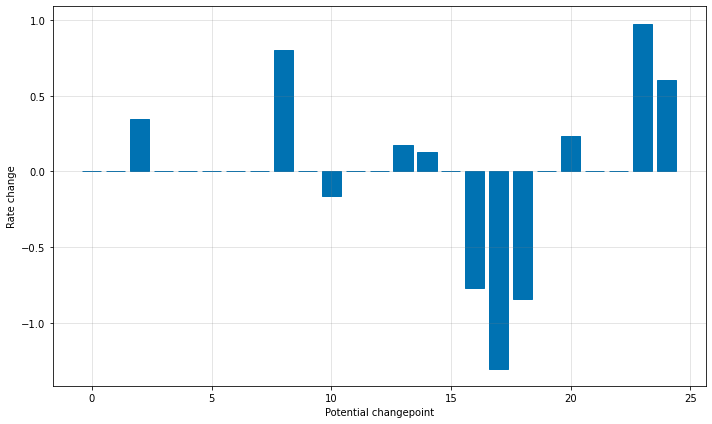

In [12]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [57]:
#https://www.statsmodels.org/stable/api.html#multivariate-time-series-models

from statsmodels.tsa.seasonal import MSTL

mstl = MSTL(
    df,
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":1001, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)
res = mstl.fit()
ax = res.plot()

ImportError: cannot import name 'MSTL' from 'statsmodels.tsa.seasonal' (C:\Users\navit\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\seasonal.py)

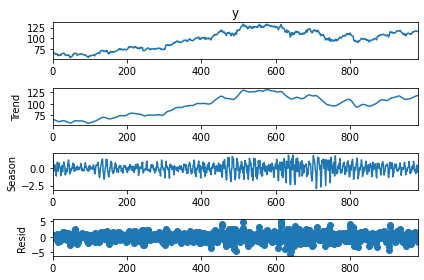

In [62]:
#https://www.statsmodels.org/stable/api.html#multivariate-time-series-models

from statsmodels.tsa.seasonal import STL

stl = STL(
    train_df['y'], period=12
)
res = stl.fit()
ax = res.plot()